In [1]:
import numpy as np
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import time
import math

In [2]:
import tsplib95
import os
import sys
from plot import plot

In [3]:
"""Scaling factor for performance times"""
time_scale_factor = 14.31/ 11.69
print(time_scale_factor)

1.2241231822070147


In [4]:
"""
Ant Colony Optimization algoritm is used. 

Objective: Making Ant colony suitable for reaching good enough solutions for larger problems
"""

'\nAnt Colony Optimization algoritm is used. \n\nObjective: Making Ant colony suitable for reaching good enough solutions for larger problems\n'

In [5]:
class Graph(object):
    
    def __init__(self, cost_matrix: list, rank: int):
        """
        :param cost_matrix:
        :param rank: rank of the cost matrix
        """
        self.matrix = cost_matrix
        self.rank = rank
        
        # noinspection PyUnusedLocal
        self.pheromone = [[1 / (rank * rank) for j in range(rank)] for i in range(rank)]

In [6]:
class ACO(object):
    
    def __init__(self, ant_count: int, generations: int, alpha: float, beta: float, rho: float, q: int,
                 strategy: int):
        """
        :param ant_count:
        :param generations:
        :param alpha: relative importance of pheromone
        :param beta: relative importance of heuristic information
        :param rho: pheromone residual coefficient
        :param q: pheromone intensity
        :param strategy: pheromone update strategy. 0 - ant-cycle, 1 - ant-quality, 2 - ant-density
        """
        self.Q = q
        self.rho = rho
        self.beta = beta
        self.alpha = alpha
        self.ant_count = ant_count
        self.generations = generations
        self.update_strategy = strategy
        # self.opt_solution = opt_solution
     
    def _update_pheromone(self, graph: Graph, ants: list):
        
        for i, row in enumerate(graph.pheromone):
            for j, col in enumerate(row):
                graph.pheromone[i][j] *= self.rho
                for ant in ants:
                    graph.pheromone[i][j] += ant.pheromone_delta[i][j]
                       
    # noinspection PyProtectedMember
    def solve(self, graph: Graph, setup_time, time_scale_factor):        
        timestamps = []
        soln_list = []
        
        print("### Solving starts ###")
        start_time = time.time()
        last_time = 0
        start_100_sec_timer = start_time
        start_20_sec_timer = start_time
        """
        :param graph:
        """
        best_cost = float('inf')
        best_solution = []
        
        for gen in range(self.generations):            
            self.alpha = self.alpha * 1.001
            
            if (time.time() - start_20_sec_timer > (20/ time_scale_factor)):
                print("Pheromone reset")
                for i in range(graph.rank):
                    for j in range(graph.rank):
                        # graph.pheromone[i][j] = graph.pheromone[i][j]
                        # graph.pheromone[i][j] = 1/ (graph.rank * graph.rank)
                        graph.pheromone[i][j] = math.sqrt(graph.pheromone[i][j])

                # print(graph.pheromone)
                self.alpha = alpha                
                print("Current Cost is:", best_cost)
                start_20_sec_timer = time.time()
            
            if (time.time() - start_100_sec_timer > 100/time_scale_factor):
                print("No improvement in last 100 seconds: Aborting!")
                break

            # noinspection PyUnusedLocal
            ants = [_Ant(self, graph) for i in range(self.ant_count)] # List of Ant class objects, each with child class "Ant" objects            
            ant_index = 0            
            for ant in ants:      # For each ant               
                for i in range(graph.rank - 1): # Consider the entire graph
                    
                    # Every ant traverses all the nodes in the graph --> fills the tabu list
                    ant._select_next()     # Also Keeps track of path cost for each ant               
                
                # Adds the cost of final node to the start node
                ant.total_cost += graph.matrix[ant.tabu[-1]][ant.tabu[0]]                
                # print("Ant {x}, Ant.tabu".format(x=ant_index), ant.tabu)

                if ant.total_cost < best_cost:
                    best_cost = ant.total_cost
                    best_solution = [] + ant.tabu
                    last_best_soln = best_solution
                    start_100_sec_timer = time.time()
                    
                   #  print(" ######################## BEST CASE ###############################")
                   #  print("Ant {x}, Ant.best_cost, Ant.best_solution".format(x=ant_index), best_cost, best_solution)                    
                ant_index += 1
                          
                # update pheromone
                ant._update_pheromone_delta()
            self._update_pheromone(graph, ants)
            
            new_time = time.time() + setup_time - start_time
            
            if (last_time <1/time_scale_factor and new_time >=1/time_scale_factor):
                sol_1s = best_solution
                sol_3s = sol_10s = sol_30s = sol_100s = sol_1s
                cost_1s = cost_3s = cost_10s = cost_30s = cost_100s = best_cost
                print("Cost at 1 second", cost_1s)
                timestamps.append(math.log(1))
                soln_list.append(cost_1s)
                
            elif (last_time <3/time_scale_factor and new_time >=3/time_scale_factor):
                sol_3s = best_solution
                sol_10s = sol_30s = sol_100s = sol_3s
                cost_3s = cost_10s = cost_30s = cost_100s = best_cost
                print("Cost at 3 second", cost_3s)
                timestamps.append(math.log(3))
                soln_list.append(cost_3s)
                
            elif (last_time <10/time_scale_factor and new_time >=10/time_scale_factor):
                sol_10s = best_solution
                sol_30s = sol_100s = sol_10s
                cost_10s = cost_30s = cost_100s = best_cost
                print("Cost at 10s", cost_10s)
                timestamps.append(math.log(10))
                soln_list.append(cost_10s)
                
            elif (last_time <30/time_scale_factor and new_time >=30/time_scale_factor):
                sol_30s = best_solution
                sol_100s = sol_30s
                cost_30s = cost_100s = best_cost
                print("Cost at 30s", cost_30s)
                timestamps.append(math.log(30))
                soln_list.append(cost_30s)
                
            elif (last_time <100/time_scale_factor and new_time >=100/time_scale_factor):
                sol_100s = best_solution
                cost_100s = best_cost
                print("Cost at 100 seconds", cost_100s)
                timestamps.append(math.log(100))
                soln_list.append(cost_100s)
                
            last_time = new_time

        comp_time = new_time/time_scale_factor
        timestamps.append(math.log(comp_time))
        soln_list.append(best_cost)    
        print("Best Cost solution", best_cost, "at time:", comp_time)
        
        # print('generation #{}, best cost: {}, path: {}'.format(gen, best_cost, best_solution))
        return best_solution, best_cost, comp_time, sol_1s, sol_3s, sol_10s, sol_30s, sol_100s, cost_1s, cost_3s, cost_10s, cost_30s, cost_100s, timestamps, soln_list


In [7]:
class _Ant(object):
    
    def __init__(self, aco: ACO, graph: Graph):
        self.colony = aco
        self.graph = graph
        self.total_cost = 0.0
        self.tabu = []  # tabu list --> do not visit already visited node, for an ant: forces coming full-circle (no small lopps)
        self.pheromone_delta = []  # the local increase of pheromone
        self.allowed = [i for i in range(graph.rank)]  # nodes which are allowed for the next selection
        self.eta = [[0 if i == j else 1/graph.matrix[i][j] for j in range(graph.rank)] for i in range(graph.rank)]  # heuristic information
        start = random.randint(0, graph.rank - 1)  # start from any node
        self.tabu.append(start)
        self.current = start
        self.allowed.remove(start)
    
    def _select_next(self):
        denominator = 0
        for i in self.allowed:
            denominator += self.graph.pheromone[self.current][i] ** self.colony.alpha * self.eta[self.current][i] ** self.colony.beta
        # noinspection PyUnusedLocal
        probabilities = [0 for i in range(self.graph.rank)]  # probabilities for moving to a node in the next step
        for i in range(self.graph.rank):
            try:
                self.allowed.index(i)  # test if allowed list contains i
                probabilities[i] = self.graph.pheromone[self.current][i] ** self.colony.alpha * \
                    self.eta[self.current][i] ** self.colony.beta / denominator
            except ValueError:
                pass  # do nothing
        # select next node by probability roulette
        selected = 0
        rand = random.random()
        for i, probability in enumerate(probabilities):
            rand -= probability
            if rand <= 0:
                selected = i
                break
        self.allowed.remove(selected)
        self.tabu.append(selected)
        self.total_cost += self.graph.matrix[self.current][selected]
        self.current = selected
      
    # noinspection PyUnusedLocal
    def _update_pheromone_delta(self):
        self.pheromone_delta = [[0 for j in range(self.graph.rank)] for i in range(self.graph.rank)]
        for _ in range(1, len(self.tabu)):
            i = self.tabu[_ - 1]
            j = self.tabu[_]
            if self.colony.update_strategy == 1:  # ant-quality system
                self.pheromone_delta[i][j] = self.colony.Q
            elif self.colony.update_strategy == 2:  # ant-density system
                # noinspection PyTypeChecker
                self.pheromone_delta[i][j] = self.colony.Q / self.graph.matrix[i][j]
            else:  # ant-cycle system
                self.pheromone_delta[i][j] = self.colony.Q / self.total_cost

{'name': 'ulysses16.tsp', 'comment': 'Odyssey of Ulysses (Groetschel/Padberg)', 'type': 'TSP', 'dimension': 16, 'edge_weight_type': 'GEO', 'display_data_type': 'COORD_DISPLAY', 'node_coords': {1: [38.24, 20.42], 2: [39.57, 26.15], 3: [40.56, 25.32], 4: [36.26, 23.12], 5: [33.48, 10.54], 6: [37.56, 12.19], 7: [38.42, 13.11], 8: [37.52, 20.44], 9: [41.23, 9.1], 10: [41.17, 13.05], 11: [36.08, -5.21], 12: [38.47, 15.13], 13: [38.15, 15.35], 14: [37.51, 15.17], 15: [35.49, 14.32], 16: [39.36, 19.56]}}
                     Problem : ulysses16.tsp


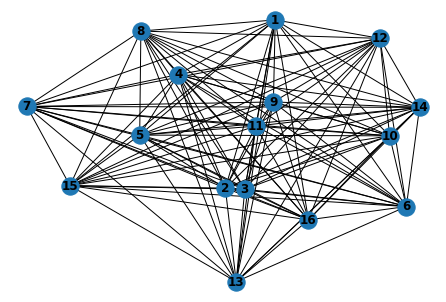

Optimal path length 6860
cities {1: [38.24, 20.42], 2: [39.57, 26.15], 3: [40.56, 25.32], 4: [36.26, 23.12], 5: [33.48, 10.54], 6: [37.56, 12.19], 7: [38.42, 13.11], 8: [37.52, 20.44], 9: [41.23, 9.1], 10: [41.17, 13.05], 11: [36.08, -5.21], 12: [38.47, 15.13], 13: [38.15, 15.35], 14: [37.51, 15.17], 15: [35.49, 14.32], 16: [39.36, 19.56]}
points dict_values([[38.24, 20.42], [39.57, 26.15], [40.56, 25.32], [36.26, 23.12], [33.48, 10.54], [37.56, 12.19], [38.42, 13.11], [37.52, 20.44], [41.23, 9.1], [41.17, 13.05], [36.08, -5.21], [38.47, 15.13], [38.15, 15.35], [37.51, 15.17], [35.49, 14.32], [39.36, 19.56]])
Setup time 0.16456866264343262 seconds
### Solving starts ###
Cost at 1 second 6915.0
Cost at 3 second 6875.0
Best Cost solution 6859.0 at time: 4.078680918484947


In [8]:
start_time = time.time()

# City graph routes
problem = tsplib95.load('tsplib95/archives/problems/tsp/ulysses16.tsp')
print(problem.as_name_dict())

G = problem.get_graph()
print("                     Problem : {i}".format(i = problem.name))
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()
A = nx.adjacency_matrix(G)
Adj = A.toarray()

points = []

q = 10 # pheromone intensity
rho = 0.9 # pheromone residual coefficient
beta = 2 # relative importance of heuristic information (1/ edge distance)
alpha = 0.6 # relative importance of pheromone
ant_count = 10 # Ant count on graph
generations = 1000 # Generations/ epochs
strategy = 0 # Ant colony strategy

"""
ACO hyperparameters
:param ant_count:
:param generations:
:param alpha: relative importance of pheromone
:param beta: relative importance of heuristic information (1/ edge distance)
:param rho: pheromone residual coefficient
:param q: pheromone intensity
:param strategy: pheromone update strategy. 0 - ant-cycle, 1 - ant-quality, 2 - ant-density
""" 

# Prepare the cities list and points
# weight = problem.get_weight(*edge)
edge_lst = list(problem.get_edges())
cities = problem.node_coords
rank = len(cities)
points = cities.values()
cost_matrix = Adj

opt = tsplib95.load('tsplib95/TSP_files/ulysses16.opt.tour')
opt_path = opt.tours[0]
opt_path.append(opt_path[0])

tour_edge_lst = []
for i in range(len(opt_path)-1):
    tour_edge_lst.append([opt_path[i]-1, opt_path[i+1]-1])
tour_edge_lst.append([opt_path[len(opt_path)-1]-1, opt_path[0]-1])

sum = 0
for i in range(len(tour_edge_lst)):
    sum += cost_matrix[tour_edge_lst[i][0]][tour_edge_lst[i][1]]
opt_weight = sum   
print("Optimal path length", opt_weight)

print("cities", cities)
print("points", points)

# ant_count, generations, alpha, beta, rho, q, strategy  
aco = ACO(ant_count, generations, alpha, beta, rho, q, strategy)
graph = Graph(cost_matrix, rank)

setup_time = time.time() - start_time
print("Setup time", setup_time, "seconds")
path, best_cost, comp_time, sol_1s, sol_3s, sol_10s, sol_30s, sol_100s, cost_1s, cost_3s, cost_10s, cost_30s, cost_100s, timestamps1, soln_list1 = aco.solve(graph, setup_time, time_scale_factor)

In [9]:
print(opt_weight)

6860


Performance time for the code is: 4.078680918484947
[0.0, 1.0986122886681098, 1.405773631849065]
[0.008017492711370262, 0.002186588921282799, -0.0001457725947521866]


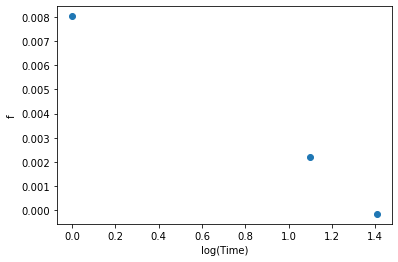

In [11]:
print("Performance time for the code is:", comp_time)
f1 = []
for i in range(len(soln_list)):
    f1.append((soln_list1[i] - opt_weight)/ opt_weight)
print(timestamps1)
print(f1)
plt.figure()
plt.plot(timestamps1, f1, 'o' )
plt.xlabel("log(Time)")
plt.ylabel("f")
plt.show()

In [12]:
path.append(path[0])
print('cost: {}, path: {}'.format(best_cost, path))

cost: 6859.0, path: [9, 8, 10, 4, 14, 5, 6, 11, 12, 13, 0, 7, 3, 1, 2, 15, 9]


dict_values([[38.24, 20.42], [39.57, 26.15], [40.56, 25.32], [36.26, 23.12], [33.48, 10.54], [37.56, 12.19], [38.42, 13.11], [37.52, 20.44], [41.23, 9.1], [41.17, 13.05], [36.08, -5.21], [38.47, 15.13], [38.15, 15.35], [37.51, 15.17], [35.49, 14.32], [39.36, 19.56]])
[9, 8, 10, 4, 14, 5, 6, 11, 12, 13, 0, 7, 3, 1, 2, 15, 9]


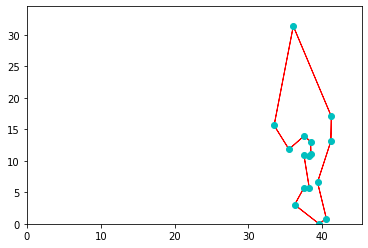

In [13]:
print(points)
print(path)
plot(points, path)

                     Problem : fri26


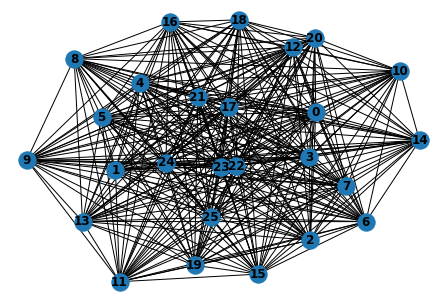

Optimal path length 937
[0, 24, 23, 22, 25, 21, 20, 16, 17, 19, 18, 15, 10, 11, 12, 14, 13, 9, 8, 7, 6, 4, 5, 3, 2, 1, 0]
Setup time 0.14358949661254883 seconds
### Solving starts ###
Cost at 1 second 979.0
Cost at 3 second 948.0
Cost at 10s 937.0
Best Cost solution 937.0 at time: 12.737114288522012


In [14]:
""" FRi26 Problem """ 

start_time = time.time()

problem = tsplib95.load('tsplib95/archives/problems/tsp/fri26.tsp')
G = problem.get_graph()
print("                     Problem : {i}".format(i = problem.name))
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()
A = nx.adjacency_matrix(G)
Adj = A.toarray()

# Prepare the cities list and points

edge_lst = list(problem.get_edges())
cost_matrix = Adj
rank = len(Adj)

q = 10 # pheromone intensity
rho = 0.9 # pheromone residual coefficient
beta = 2.5 # relative importance of heuristic information (1/ edge distance)
alpha = 0.5 # relative importance of pheromone
ant_count = int(rank/2) # Ant count on graph
generations = 1000 # Generations/ epochs
strategy = 0 # Ant colony strategy

opt = tsplib95.load('tsplib95/TSP_files/fri26.opt.tour')
opt_path = opt.tours[0]
opt_path.append(opt_path[0])

tour_edge_lst = []
for i in range(len(opt_path)-1):
    tour_edge_lst.append([opt_path[i]-1, opt_path[i+1]-1])
tour_edge_lst.append([opt_path[len(opt_path)-1]-1, opt_path[0]-1])

sum = 0
for i in range(len(tour_edge_lst)):
    sum += cost_matrix[tour_edge_lst[i][0]][tour_edge_lst[i][1]]
opt_weight = sum   
print("Optimal path length", opt_weight)

for i in range(len(opt_path)):
    opt_path[i] = opt_path[i] - 1
print(opt_path)

# ant_count, generations, alpha, beta, rho, q, strategy  
aco = ACO(ant_count, generations, alpha, beta, rho, q, strategy)
graph = Graph(cost_matrix, rank)

setup_time = time.time() - start_time
print("Setup time", setup_time, "seconds")
path, best_cost, comp_time, sol_1s, sol_3s, sol_10s, sol_30s, sol_100s, cost_1s, cost_3s, cost_10s, cost_30s, cost_100s, timestamps, soln_list = aco.solve(graph, setup_time, time_scale_factor)
# Cost already includes the cost of travelling back to the original node
path.append(path[0])

cost: 937.0, path: [6, 7, 8, 9, 13, 14, 12, 11, 10, 15, 18, 19, 17, 16, 20, 21, 25, 22, 23, 24, 0, 1, 2, 3, 5, 4, 6]
Difference between ACO and optimal solutions is 0.0
Performance time for the code is: 12.737114288522012
[0.0, 1.0986122886681098, 2.302585092994046, 2.5445201165219085]
[0.044823906083244394, 0.011739594450373533, 0.0, 0.0]


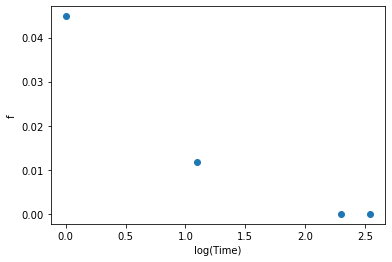

In [15]:
print('cost: {}, path: {}'.format(best_cost, path))
print("Difference between ACO and optimal solutions is", best_cost - opt_weight)

print("Performance time for the code is:", comp_time)
f = []
for i in range(len(soln_list)):
    f.append((soln_list[i] - opt_weight)/ opt_weight)
print(timestamps)
print(f)
plt.figure()
plt.plot(timestamps, f, 'o' )
plt.xlabel("log(Time)")
plt.ylabel("f")
plt.show()

Ant Colony TSP Solution for the above problem


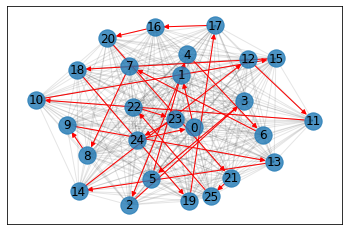

In [16]:
# Display the traversal
pos = nx.spring_layout(G)
tour_edge_lst = []
for i in range(len(path)-1):
    tour_edge_lst.append([path[i], path[i+1]])
tour_edge_lst.append([path[len(path)-1], path[0]])
# tour_edge_lst

nx.draw_networkx_nodes(G, pos=pos, alpha=0.8) # draw nodes
nx.draw_networkx_edges(G, pos=pos, alpha=0.1) # draw all edges with transparency
nx.draw_networkx_labels(G, pos= pos)
H = nx.DiGraph(G) # convert to directed graph s.t. the edges have arrows. 
nx.draw_networkx_edges(H, pos=pos, edgelist = tour_edge_lst, edge_color='red') # highlight the edges in the path

print("Ant Colony TSP Solution for the above problem")
plt.show()

In [17]:
""" 
Att48 problem:

Tried playing with number of ants: 10 -> 15 -- worsens the path taken -- logical intuition being 
the crowding of random pheromones which might require larger runs for better convergence.

Tried something like SA: growing importance of pheromones as generation progress.

"""

' \nAtt48 problem:\n\nTried playing with number of ants: 10 -> 15 -- worsens the path taken -- logical intuition being \nthe crowding of random pheromones which might require larger runs for better convergence.\n\nTried something like SA: growing importance of pheromones as generation progress.\n\n'

                     Problem : att48


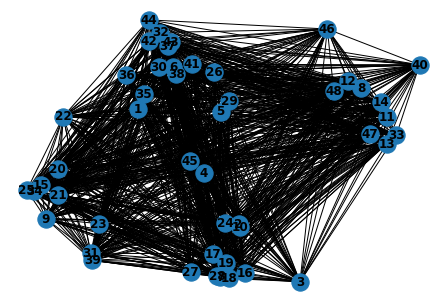

{'name': 'att48', 'comment': '48 capitals of the US (Padberg/Rinaldi)', 'type': 'TSP', 'dimension': 48, 'edge_weight_type': 'ATT', 'node_coords': {1: [6734, 1453], 2: [2233, 10], 3: [5530, 1424], 4: [401, 841], 5: [3082, 1644], 6: [7608, 4458], 7: [7573, 3716], 8: [7265, 1268], 9: [6898, 1885], 10: [1112, 2049], 11: [5468, 2606], 12: [5989, 2873], 13: [4706, 2674], 14: [4612, 2035], 15: [6347, 2683], 16: [6107, 669], 17: [7611, 5184], 18: [7462, 3590], 19: [7732, 4723], 20: [5900, 3561], 21: [4483, 3369], 22: [6101, 1110], 23: [5199, 2182], 24: [1633, 2809], 25: [4307, 2322], 26: [675, 1006], 27: [7555, 4819], 28: [7541, 3981], 29: [3177, 756], 30: [7352, 4506], 31: [7545, 2801], 32: [3245, 3305], 33: [6426, 3173], 34: [4608, 1198], 35: [23, 2216], 36: [7248, 3779], 37: [7762, 4595], 38: [7392, 2244], 39: [3484, 2829], 40: [6271, 2135], 41: [4985, 140], 42: [1916, 1569], 43: [7280, 4899], 44: [7509, 3239], 45: [10, 2676], 46: [6807, 2993], 47: [5185, 3258], 48: [3023, 1942]}}
[1, 8, 38

In [18]:
""" Att48 Problem """ 

start_time = time.time()

problem = tsplib95.load('tsplib95/archives/problems/tsp/att48.tsp')
G = problem.get_graph()
print("                     Problem : {i}".format(i = problem.name))
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()
A = nx.adjacency_matrix(G)
Adj = A.toarray()

print(problem.as_name_dict())

# Prepare the cities list and points=
edge_lst = list(problem.get_edges())
cities = problem.node_coords 
points = cities.values()
cost_matrix = Adj
rank = len(Adj)

q = 10 # pheromone intensity
rho = 0.9 # pheromone residual coefficient
beta = 2.5 # relative importance of heuristic information (1/ edge distance)
alpha = 0.5 # relative importance of pheromone
ant_count = int(rank) # Ant count on graph
generations = 1000 # Generations/ epochs
strategy = 0 # Ant colony strategy

opt = tsplib95.load('tsplib95/TSP_files/att48.opt.tour')
opt_path = opt.tours[0]
opt_path.append(opt_path[0])
print(opt_path)

tour_edge_lst = []
for i in range(len(opt_path)-1):
    tour_edge_lst.append([opt_path[i]-1, opt_path[i+1]-1])
tour_edge_lst.append([opt_path[len(opt_path)-1]-1, opt_path[0]-1])

sum = 0
for i in range(len(tour_edge_lst)):
    sum += cost_matrix[tour_edge_lst[i][0]][tour_edge_lst[i][1]]
opt_weight = sum   
print("Optimal path length", opt_weight)

# ant_count, generations, alpha, beta, rho, q, strategy  
aco = ACO(ant_count, generations, alpha, beta, rho, q, strategy)
graph = Graph(cost_matrix, rank)

setup_time = time.time() - start_time
print("Setup time", setup_time, "seconds")
path, best_cost, comp_time, sol_1s, sol_3s, sol_10s, sol_30s, sol_100s, cost_1s, cost_3s, cost_10s, cost_30s, cost_100s, timestamps, soln_list = aco.solve(graph, setup_time, time_scale_factor)
path.append(path[0])

print('cost: {}, path: {}'.format(best_cost, path))


cost: 11537.0, path: [41, 4, 47, 38, 31, 20, 12, 24, 13, 22, 10, 46, 19, 14, 11, 32, 45, 37, 30, 43, 17, 6, 27, 5, 29, 18, 36, 26, 42, 16, 35, 39, 8, 0, 7, 21, 15, 2, 33, 40, 28, 1, 3, 25, 34, 44, 9, 23, 41]
Difference between ACO and optimal solutions is 909.0
Performance time for the code is: 163.91608674554536
[0.0, 1.0986122886681098, 2.302585092994046, 3.4011973816621555, 4.605170185988092, 5.099354630692687]
[0.41691757621377495, 0.20681219420398947, 0.1241061347384268, 0.1241061347384268, 0.11676703048550997, 0.08552879187053067]


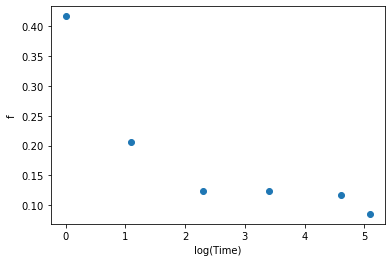

In [19]:
print('cost: {}, path: {}'.format(best_cost, path))
print("Difference between ACO and optimal solutions is", best_cost - opt_weight)

print("Performance time for the code is:", comp_time)
f = []
for i in range(len(soln_list)):
    f.append((soln_list[i] - opt_weight)/ opt_weight)
print(timestamps)
print(f)
plt.figure()
plt.plot(timestamps, f, 'o' )
plt.xlabel("log(Time)")
plt.ylabel("f")
plt.show()

Algorithm Solution


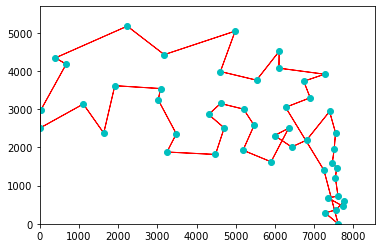

Optimal Solution


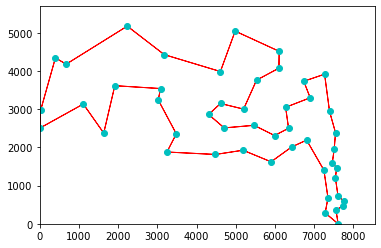

In [20]:
print("Algorithm Solution")
plot(points, path)
for i in range(len(opt_path)):
    opt_path[i] = opt_path[i] - 1
print("Optimal Solution")
plot(points, opt_path)

                     Problem : pr76


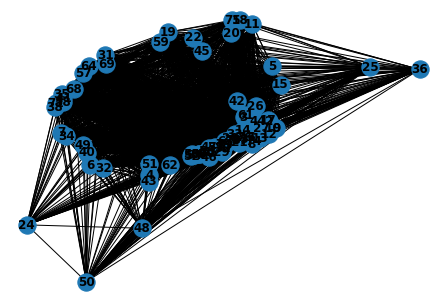

{'name': 'pr76', 'comment': '76-city problem (Padberg/Rinaldi)', 'type': 'TSP', 'dimension': 76, 'edge_weight_type': 'EUC_2D', 'node_coords': {1: [3600, 2300], 2: [3100, 3300], 3: [4700, 5750], 4: [5400, 5750], 5: [5608, 7103], 6: [4493, 7102], 7: [3600, 6950], 8: [3100, 7250], 9: [4700, 8450], 10: [5400, 8450], 11: [5610, 10053], 12: [4492, 10052], 13: [3600, 10800], 14: [3100, 10950], 15: [4700, 11650], 16: [5400, 11650], 17: [6650, 10800], 18: [7300, 10950], 19: [7300, 7250], 20: [6650, 6950], 21: [7300, 3300], 22: [6650, 2300], 23: [5400, 1600], 24: [8350, 2300], 25: [7850, 3300], 26: [9450, 5750], 27: [10150, 5750], 28: [10358, 7103], 29: [9243, 7102], 30: [8350, 6950], 31: [7850, 7250], 32: [9450, 8450], 33: [10150, 8450], 34: [10360, 10053], 35: [9242, 10052], 36: [8350, 10800], 37: [7850, 10950], 38: [9450, 11650], 39: [10150, 11650], 40: [11400, 10800], 41: [12050, 10950], 42: [12050, 7250], 43: [11400, 6950], 44: [12050, 3300], 45: [11400, 2300], 46: [10150, 1600], 47: [13100

In [33]:
""" pr76 Problem """ 

start_time = time.time()

problem = tsplib95.load('tsplib95/archives/problems/tsp/pr76.tsp')
G = problem.get_graph()
print("                     Problem : {i}".format(i = problem.name))
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()
A = nx.adjacency_matrix(G)
Adj = A.toarray()

print(problem.as_name_dict())

# Prepare the cities list and points=
edge_lst = list(problem.get_edges())
cities = problem.node_coords 
points = cities.values()
cost_matrix = Adj
rank = len(Adj)

q = 10 # pheromone intensity
rho = 0.9 # pheromone residual coefficient
beta = 2.5 # relative importance of heuristic information (1/ edge distance)
alpha = 0.5 # relative importance of pheromone
ant_count = int(rank) # Ant count on graph
generations = 1000 # Generations/ epochs
strategy = 0 # Ant colony strategy

opt = tsplib95.load('tsplib95/TSP_files/pr76.opt.tour')
opt_path = opt.tours[0]
opt_path.append(opt_path[0])
print(opt_path)

tour_edge_lst = []
for i in range(len(opt_path)-1):
    tour_edge_lst.append([opt_path[i]-1, opt_path[i+1]-1])
tour_edge_lst.append([opt_path[len(opt_path)-1]-1, opt_path[0]-1])

sum = 0
for i in range(len(tour_edge_lst)):
    sum += cost_matrix[tour_edge_lst[i][0]][tour_edge_lst[i][1]]
opt_weight = sum   
print("Optimal path length", opt_weight)

# ant_count, generations, alpha, beta, rho, q, strategy  
aco = ACO(ant_count, generations, alpha, beta, rho, q, strategy)
graph = Graph(cost_matrix, rank)

setup_time = time.time() - start_time
print("Setup time", setup_time, "seconds")
path, best_cost, comp_time, sol_1s, sol_3s, sol_10s, sol_30s, sol_100s, cost_1s, cost_3s, cost_10s, cost_30s, cost_100s, timestamps, soln_list = aco.solve(graph, setup_time, time_scale_factor)
path.append(path[0])

print('cost: {}, path: {}'.format(best_cost, path))


cost: 131709.0, path: [3, 2, 6, 7, 5, 4, 30, 29, 28, 25, 26, 42, 41, 53, 52, 48, 49, 50, 55, 54, 51, 65, 64, 63, 62, 61, 60, 58, 59, 40, 39, 34, 33, 31, 32, 18, 19, 9, 8, 11, 10, 15, 14, 12, 13, 73, 75, 74, 1, 0, 22, 21, 20, 24, 23, 45, 44, 43, 47, 46, 68, 67, 66, 69, 70, 71, 72, 56, 57, 37, 38, 35, 36, 17, 16, 27, 3]
Difference between ACO and optimal solutions is 23550.0
Performance time for the code is: 81.07656059125183
[0.0, 1.0986122886681098, 2.302585092994046, 3.4011973816621555, 4.605170185988092, 4.395393900743889]
[0.8551484388724008, 0.5384665168871754, 0.30147283166449396, 0.21773500124816242, 0.21773500124816242, 0.21773500124816242]


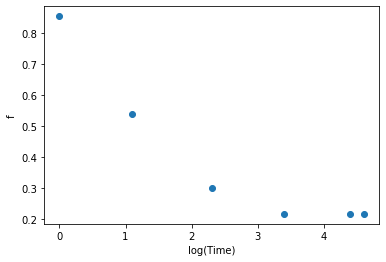

In [34]:
print('cost: {}, path: {}'.format(best_cost, path))
print("Difference between ACO and optimal solutions is", best_cost - opt_weight)

print("Performance time for the code is:", comp_time)
f = []
for i in range(len(soln_list)):
    f.append((soln_list[i] - opt_weight)/ opt_weight)
print(timestamps)
print(f)
plt.figure()
plt.plot(timestamps, f, 'o' )
plt.xlabel("log(Time)")
plt.ylabel("f")
plt.show()

In [21]:
""" gr120 Problem """ 

start_time = time.time()

problem = tsplib95.load('tsplib95/archives/problems/tsp/gr120.tsp')
G = problem.get_graph()
print("                     Problem : {i}".format(i = problem.name))
# nx.draw(G, with_labels=True, font_weight='bold')
# plt.show()
A = nx.adjacency_matrix(G)
Adj = A.toarray()

# Prepare the cities list and points=
edge_lst = list(problem.get_edges())
cities = problem.node_coords 
points = cities.values()
cost_matrix = Adj
rank = len(Adj)

q = 100 # pheromone intensity
rho = 0.5 # pheromone residual coefficient
beta = 5 # relative importance of heuristic information (1/ edge distance)
alpha = 1 # relative importance of pheromone
ant_count = int(rank/10) # Ant count on graph
generations = 1000 # Generations/ epochs
strategy = 0 # Ant colony strategy

opt = tsplib95.load('tsplib95/TSP_files/gr120.opt.tour')
opt_path = opt.tours[0]
opt_path.append(opt_path[0])
print(opt_path)

tour_edge_lst = []
for i in range(len(opt_path)-1):
    tour_edge_lst.append([opt_path[i]-1, opt_path[i+1]-1])
tour_edge_lst.append([opt_path[len(opt_path)-1]-1, opt_path[0]-1])

sum = 0
for i in range(len(tour_edge_lst)):
    sum += cost_matrix[tour_edge_lst[i][0]][tour_edge_lst[i][1]]
opt_weight = sum   
print("Optimal path length", opt_weight)

# ant_count, generations, alpha, beta, rho, q, strategy  
aco = ACO(ant_count, generations, alpha, beta, rho, q, strategy)
graph = Graph(cost_matrix, rank)

setup_time = time.time() - start_time
print("Setup time", setup_time, "seconds")
path, best_cost, comp_time, sol_1s, sol_3s, sol_10s, sol_30s, sol_100s, cost_1s, cost_3s, cost_10s, cost_30s, cost_100s, timestamps, soln_list = aco.solve(graph, setup_time, time_scale_factor)
path.append(path[0])

                     Problem : gr120
[1, 76, 59, 15, 30, 29, 120, 32, 92, 28, 45, 78, 86, 94, 81, 22, 66, 31, 117, 85, 18, 19, 25, 108, 43, 79, 52, 33, 100, 58, 91, 68, 65, 69, 113, 107, 20, 46, 50, 44, 75, 14, 87, 74, 105, 40, 72, 38, 7, 56, 41, 42, 98, 17, 118, 49, 13, 51, 11, 23, 9, 103, 119, 3, 82, 2, 115, 21, 93, 53, 64, 109, 88, 97, 12, 95, 77, 39, 63, 5, 27, 80, 101, 102, 48, 110, 112, 106, 114, 73, 57, 83, 67, 37, 62, 99, 10, 35, 104, 36, 84, 6, 89, 55, 47, 71, 26, 4, 34, 116, 70, 8, 54, 90, 96, 111, 24, 60, 16, 61, 1]
Optimal path length 6942
Setup time 0.10471820831298828 seconds
### Solving starts ###
Cost at 1 second 8824.0
Cost at 3 second 8518.0
Cost at 10s 8289.0
Pheromone reset
Current Cost is: 8239.0
Cost at 30s 8239.0
Pheromone reset
Current Cost is: 8239.0
Pheromone reset
Current Cost is: 8035.0
Pheromone reset
Current Cost is: 8035.0
Cost at 100 seconds 7898.0
Pheromone reset
Current Cost is: 7898.0
Pheromone reset
Current Cost is: 7898.0
Pheromone reset
Current Cos

cost: 7898.0, path: [42, 64, 68, 112, 106, 19, 45, 49, 97, 41, 16, 117, 48, 12, 40, 55, 6, 37, 39, 71, 104, 73, 86, 13, 74, 43, 85, 93, 80, 77, 44, 27, 91, 31, 29, 28, 119, 60, 15, 59, 23, 110, 95, 89, 53, 7, 69, 115, 33, 25, 3, 118, 102, 8, 22, 10, 50, 114, 1, 81, 2, 79, 26, 4, 62, 76, 63, 108, 92, 20, 87, 96, 11, 94, 38, 82, 56, 72, 113, 105, 111, 109, 100, 101, 47, 46, 70, 54, 88, 5, 35, 83, 34, 9, 103, 98, 61, 36, 66, 52, 0, 75, 58, 14, 65, 30, 116, 84, 21, 17, 18, 24, 107, 78, 57, 99, 32, 51, 90, 67, 42]
Difference between ACO and optimal solutions is 956.0
Performance time for the code is: 130.3476681704291
[0.0, 1.0986122886681098, 2.302585092994046, 3.4011973816621555, 4.605170185988092, 4.870205251231615]
[0.2711034284067992, 0.22702391241717085, 0.19403630077787382, 0.1868337654854509, 0.13771247479112647, 0.13771247479112647]


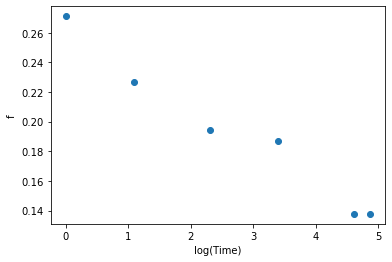

In [22]:
print('cost: {}, path: {}'.format(best_cost, path))
print("Difference between ACO and optimal solutions is", best_cost - opt_weight)

print("Performance time for the code is:", comp_time)
f = []
for i in range(len(soln_list)):
    f.append((soln_list[i] - opt_weight)/ opt_weight)
print(timestamps)
print(f)
plt.figure()
plt.plot(timestamps, f, 'o' )
plt.xlabel("log(Time)")
plt.ylabel("f")
plt.show()

In [23]:
""" ts225 Problem """ 

start_time = time.time()

problem = tsplib95.load('tsplib95/archives/problems/tsp/ts225.tsp')
G = problem.get_graph()
print("                     Problem : {i}".format(i = problem.name))
# nx.draw(G, with_labels=True, font_weight='bold')
# plt.show()
A = nx.adjacency_matrix(G)
Adj = A.toarray()

# Prepare the cities list and points=
edge_lst = list(problem.get_edges())
cities = problem.node_coords 
points = cities.values()
cost_matrix = Adj
rank = len(Adj)
"""
q = 10 # pheromone intensity
rho = 0.9 # pheromone residual coefficient
beta = 2.5 # relative importance of heuristic information (1/ edge distance)
alpha = 0.5 # relative importance of pheromone
ant_count = int(rank/10) # Ant count on graph
generations = 1000 # Generations/ epochs
strategy = 0 # Ant colony strategy
"""
q = 100 # pheromone intensity
rho = 0.5 # pheromone residual coefficient
beta = 5 # relative importance of heuristic information (1/ edge distance)
alpha = 1 # relative importance of pheromone
ant_count = int(rank/10) # Ant count on graph
generations = 1000 # Generations/ epochs
strategy = 0 # Ant colony strategy

opt_weight = 126643

# ant_count, generations, alpha, beta, rho, q, strategy  
aco = ACO(ant_count, generations, alpha, beta, rho, q, strategy)
graph = Graph(cost_matrix, rank)

setup_time = time.time() - start_time
print("Setup time", setup_time, "seconds")
path, best_cost, comp_time, sol_1s, sol_3s, sol_10s, sol_30s, sol_100s, cost_1s, cost_3s, cost_10s, cost_30s, cost_100s, timestamps, soln_list = aco.solve(graph, setup_time, time_scale_factor)
path.append(path[0])

print('cost: {}, path: {}'.format(best_cost, path))

                     Problem : ts225
Setup time 0.38596677780151367 seconds
### Solving starts ###
Cost at 1 second 172565.0
Cost at 10s 147736.0
Pheromone reset
Current Cost is: 147736.0
Cost at 30s 145217.0
Pheromone reset
Current Cost is: 142200.0
Pheromone reset
Current Cost is: 140131.0
Pheromone reset
Current Cost is: 138128.0
Cost at 100 seconds 138128.0
Pheromone reset
Current Cost is: 138128.0
Pheromone reset
Current Cost is: 138128.0
Pheromone reset
Current Cost is: 135996.0
Pheromone reset
Current Cost is: 135996.0
Pheromone reset
Current Cost is: 135996.0
Pheromone reset
Current Cost is: 135996.0
No improvement in last 100 seconds: Aborting!
Best Cost solution 135996.0 at time: 152.96319311786414
cost: 135996.0, path: [124, 123, 122, 121, 120, 119, 118, 219, 218, 217, 216, 215, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 205, 206, 207, 208, 209, 106, 105, 104, 103, 102, 101, 100, 204, 203, 202, 201, 200, 75, 76, 77, 78, 79, 80, 184, 183, 182, 181, 180, 56, 55, 54, 53, 5

cost: 135996.0, path: [124, 123, 122, 121, 120, 119, 118, 219, 218, 217, 216, 215, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 205, 206, 207, 208, 209, 106, 105, 104, 103, 102, 101, 100, 204, 203, 202, 201, 200, 75, 76, 77, 78, 79, 80, 184, 183, 182, 181, 180, 56, 55, 54, 53, 52, 51, 50, 175, 176, 177, 178, 179, 154, 153, 152, 151, 150, 25, 129, 128, 127, 126, 125, 0, 1, 2, 3, 4, 5, 6, 130, 131, 132, 133, 134, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 165, 166, 167, 168, 169, 68, 69, 70, 71, 72, 73, 74, 174, 173, 172, 171, 170, 49, 149, 148, 147, 146, 145, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 135, 136, 137, 138, 139, 160, 161, 162, 163, 164, 63, 64, 65, 66, 67, 190, 191, 192, 193, 194, 93, 94, 95, 96, 97, 221, 222, 223, 224, 220, 99, 98, 199, 198, 197, 196, 195, 48, 47, 46, 45, 44, 144, 143, 142, 141, 140, 11, 10, 9, 8, 7, 29, 28, 27, 26, 30, 155, 156, 157, 158, 159, 57, 58, 59, 60, 61, 62, 185, 186, 187, 188, 189, 210, 211, 212, 213, 214, 112, 111, 110, 10

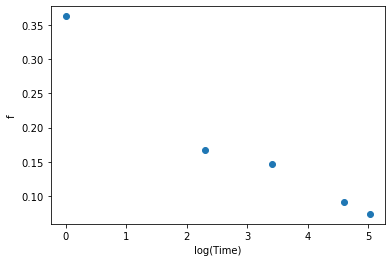

In [24]:
print('cost: {}, path: {}'.format(best_cost, path))
print("Difference between ACO and optimal solutions is", best_cost - opt_weight)

print("Performance time for the code is:", comp_time)
f = []
for i in range(len(soln_list)):
    f.append((soln_list[i] - opt_weight)/ opt_weight)
print(timestamps)
print(f)
plt.figure()
plt.plot(timestamps, f, 'o' )
plt.xlabel("log(Time)")
plt.ylabel("f")
plt.show()

In [25]:
""" d493 Problem """ 

start_time = time.time()

problem = tsplib95.load('tsplib95/archives/problems/tsp/d493.tsp')
G = problem.get_graph()
print("                     Problem : {i}".format(i = problem.name))
# nx.draw(G, with_labels=True, font_weight='bold')
# plt.show()
A = nx.adjacency_matrix(G)
Adj = A.toarray()

# Prepare the cities list and points=
edge_lst = list(problem.get_edges())
cities = problem.node_coords 
points = cities.values()
cost_matrix = Adj
rank = len(Adj)

q = 100 # pheromone intensity
rho = 0.5 # pheromone residual coefficient
beta = 5 # relative importance of heuristic information (1/ edge distance)
alpha = 1 # relative importance of pheromone
ant_count = int(rank/10) # Ant count on graph
generations = 1000 # Generations/ epochs
strategy = 0 # Ant colony strategy

opt_weight = 35002

# ant_count, generations, alpha, beta, rho, q, strategy  
aco = ACO(ant_count, generations, alpha, beta, rho, q, strategy)
graph = Graph(cost_matrix, rank)

setup_time = time.time() - start_time
print("Setup time", setup_time, "seconds")
path, best_cost, comp_time, sol_1s, sol_3s, sol_10s, sol_30s, sol_100s, cost_1s, cost_3s, cost_10s, cost_30s, cost_100s, timestamps, soln_list = aco.solve(graph, setup_time, time_scale_factor)
path.append(path[0])

print('cost: {}, path: {}'.format(best_cost, path))

                     Problem : d493
Setup time 1.7787196636199951 seconds
### Solving starts ###
Cost at 1 second 50519.0
Pheromone reset
Current Cost is: 50519.0
Pheromone reset
Current Cost is: 45562.0
Cost at 100 seconds 45562.0
Pheromone reset
Current Cost is: 45562.0
Pheromone reset
Current Cost is: 45562.0
No improvement in last 100 seconds: Aborting!
Best Cost solution 45562.0 at time: 115.25544927438432
cost: 45562.0, path: [456, 24, 25, 398, 391, 384, 421, 422, 428, 390, 397, 368, 369, 370, 351, 340, 324, 316, 309, 298, 277, 270, 272, 266, 240, 275, 271, 267, 254, 239, 215, 208, 209, 224, 200, 175, 173, 179, 185, 188, 184, 178, 197, 196, 181, 168, 171, 183, 201, 202, 206, 218, 226, 232, 237, 245, 246, 247, 259, 258, 257, 244, 243, 242, 255, 241, 233, 228, 227, 216, 211, 212, 207, 210, 205, 217, 222, 230, 235, 229, 214, 221, 234, 265, 268, 300, 304, 276, 297, 333, 341, 344, 325, 296, 357, 348, 363, 356, 342, 349, 336, 322, 317, 329, 320, 305, 288, 278, 279, 280, 281, 282, 293, 

Difference between ACO and optimal solutions is 10560.0
Performance time for the code is: 115.25544927438432
[0.0, 4.605170185988092, 4.747150962966229]
[0.44331752471287356, 0.3016970458830924, 0.3016970458830924]


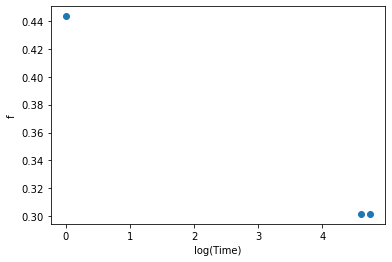

In [26]:
print("Difference between ACO and optimal solutions is", best_cost - opt_weight)
print("Performance time for the code is:", comp_time)
f = []
for i in range(len(soln_list)):
    f.append((soln_list[i] - opt_weight)/ opt_weight)
print(timestamps)
print(f)
plt.figure()
plt.plot(timestamps, f, 'o' )
plt.xlabel("log(Time)")
plt.ylabel("f")
plt.show()

In [27]:
""" rat783 Problem """ 

start_time = time.time()

problem = tsplib95.load('tsplib95/archives/problems/tsp/rat783.tsp')
G = problem.get_graph()
print("                     Problem : {i}".format(i = problem.name))
# nx.draw(G, with_labels=True, font_weight='bold')
# plt.show()
A = nx.adjacency_matrix(G)
Adj = A.toarray()

# Prepare the cities list and points=
edge_lst = list(problem.get_edges())
cities = problem.node_coords 
points = cities.values()
cost_matrix = Adj
rank = len(Adj)

q = 100 # pheromone intensity
rho = 0.5 # pheromone residual coefficient
beta = 5 # relative importance of heuristic information (1/ edge distance)
alpha = 1 # relative importance of pheromone
ant_count = int(rank/10) # Ant count on graph
generations = 100 # Generations/ epochs
strategy = 0 # Ant colony strategy

opt_weight = 8806

# ant_count, generations, alpha, beta, rho, q, strategy  
aco = ACO(ant_count, generations, alpha, beta, rho, q, strategy)
graph = Graph(cost_matrix, rank)

setup_time = time.time() - start_time
print("Setup time", setup_time, "seconds")
path, best_cost, comp_time, sol_1s, sol_3s, sol_10s, sol_30s, sol_100s, cost_1s, cost_3s, cost_10s, cost_30s, cost_100s, timestamps, soln_list = aco.solve(graph, setup_time, time_scale_factor)
path.append(path[0])

print('cost: {}, path: {}'.format(best_cost, path))

                     Problem : rat783
Setup time 4.512236595153809 seconds
### Solving starts ###
Cost at 1 second 13299.0
Pheromone reset
Current Cost is: 13299.0
Pheromone reset
Current Cost is: 11558.0
Pheromone reset
Current Cost is: 11558.0
No improvement in last 100 seconds: Aborting!
Best Cost solution 11558.0 at time: 435.8664929551898
cost: 11558.0, path: [602, 586, 590, 583, 599, 600, 613, 604, 588, 609, 617, 638, 630, 632, 629, 635, 621, 608, 620, 627, 616, 618, 612, 611, 626, 633, 640, 643, 659, 674, 689, 684, 678, 670, 677, 687, 704, 708, 717, 734, 744, 735, 742, 738, 731, 721, 732, 736, 718, 719, 698, 694, 685, 683, 660, 656, 648, 680, 690, 691, 706, 712, 697, 679, 654, 644, 647, 651, 658, 671, 682, 696, 703, 724, 737, 733, 746, 760, 771, 759, 764, 757, 756, 758, 775, 767, 778, 776, 772, 773, 765, 747, 739, 725, 720, 709, 699, 700, 692, 672, 661, 653, 652, 645, 650, 665, 668, 563, 562, 565, 577, 587, 598, 589, 597, 596, 593, 585, 579, 610, 625, 637, 639, 623, 595, 575, 56

Difference between ACO and optimal solutions is 2752.0
Performance time for the code is: 435.8664929551898
[0.0, 6.077335987639169]
[0.5102203043379514, 0.31251419486713605]


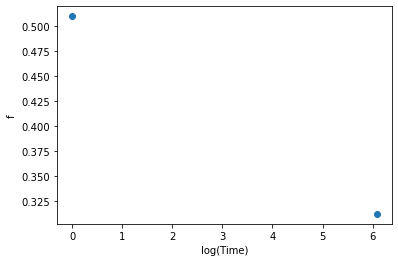

In [28]:
print("Difference between ACO and optimal solutions is", best_cost - opt_weight)
print("Performance time for the code is:", comp_time)
f = []
for i in range(len(soln_list)):
    f.append((soln_list[i] - opt_weight)/ opt_weight)
print(timestamps)
print(f)
plt.figure()
plt.plot(timestamps, f, 'o' )
plt.xlabel("log(Time)")
plt.ylabel("f")
plt.show()

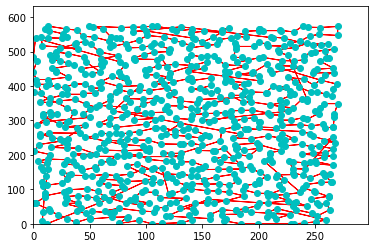

In [29]:
# print(points)
# print(path)
plot(points, path)

In [58]:
""" CHALLENGE PROBLEM """

""" u1060 Problem """ 

start_time = time.time()

problem = tsplib95.load('tsplib95/archives/problems/tsp/u1060.tsp')
G = problem.get_graph()
print("                     Problem : {i}".format(i = problem.name))
# nx.draw(G, with_labels=True, font_weight='bold')
# plt.show()
A = nx.adjacency_matrix(G)
Adj = A.toarray()

q = 10 # pheromone intensity
rho = 0.7 # pheromone residual coefficient
beta = 5 # relative importance of heuristic information (1/ edge distance)
alpha = 1 # relative importance of pheromone
ant_count = 100 # Ant count on graph
generations = 1000 # Generations/ epochs
strategy = 0 # Ant colony strategy

# Prepare the cities list and points=
edge_lst = list(problem.get_edges())
cities = problem.node_coords 
points = cities.values()
cost_matrix = Adj
rank = len(Adj)

opt_weight = 224094

# ant_count, generations, alpha, beta, rho, q, strategy  
aco = ACO(ant_count, generations, alpha, beta, rho, q, strategy)
graph = Graph(cost_matrix, rank)

setup_time = time.time() - start_time
print("Setup time", setup_time, "seconds")
path, best_cost, comp_time, sol_1s, sol_3s, sol_10s, sol_30s, sol_100s, cost_1s, cost_3s, cost_10s, cost_30s, cost_100s, timestamps, soln_list = aco.solve(graph, setup_time, time_scale_factor)
path.append(path[0])

# print('cost: {}, path: {}'.format(best_cost, path))

                     Problem : u1060
Setup time 8.482628583908081 seconds
### Solving starts ###
Cost at 1 second 345836.0
Pheromone reset
Current Cost is: 345836.0
Pheromone reset
Current Cost is: 316845.0
No improvement in last 100 seconds: Aborting!
Best Cost solution 316845.0 at time: 899.2883088627034


Difference between ACO and optimal solutions is 92751.0
Performance time for the code is: 899.2883088627034
[0.0, 6.801603682572098]
[0.5432630949512258, 0.4138932769284318]


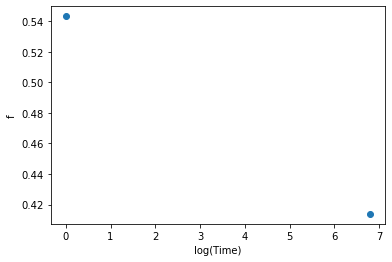

In [59]:
print("Difference between ACO and optimal solutions is", best_cost - opt_weight)
print("Performance time for the code is:", comp_time)
f = []
for i in range(len(soln_list)):
    f.append((soln_list[i] - opt_weight)/ opt_weight)
print(timestamps)
print(f)
plt.figure()
plt.plot(timestamps, f, 'o' )
plt.xlabel("log(Time)")
plt.ylabel("f")
plt.show()

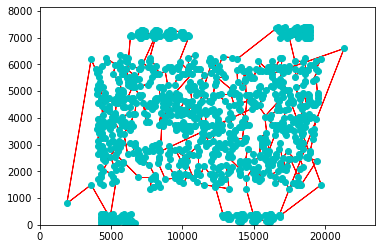

In [60]:
plot(points, path)

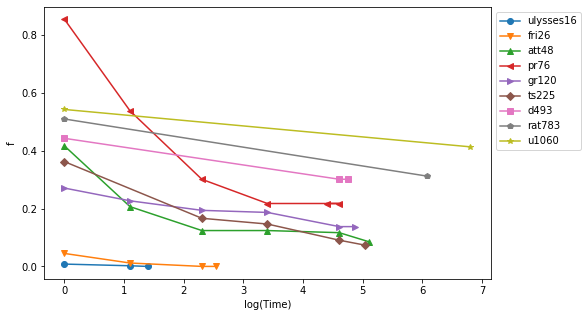

In [61]:
t1= [0.0, 1.0986122886681098, 1.405773631849065]
f1= [0.008017492711370262, 0.002186588921282799, -0.0001457725947521866]

t2 = [0.0, 1.0986122886681098, 2.302585092994046, 2.5445201165219085]
f2 = [0.044823906083244394, 0.011739594450373533, 0.0, 0.0]

t3 = [0.0, 1.0986122886681098, 2.302585092994046, 3.4011973816621555, 4.605170185988092, 5.099354630692687]
f3 = [0.41691757621377495, 0.20681219420398947, 0.1241061347384268, 0.1241061347384268, 0.11676703048550997, 0.08552879187053067]

t4 = [0.0, 1.0986122886681098, 2.302585092994046, 3.4011973816621555, 4.605170185988092, 4.395393900743889]
f4 = [0.8551484388724008, 0.5384665168871754, 0.30147283166449396, 0.21773500124816242, 0.21773500124816242, 0.21773500124816242]

t5 = [0.0, 1.0986122886681098, 2.302585092994046, 3.4011973816621555, 4.605170185988092, 4.870205251231615]
f5 = [0.2711034284067992, 0.22702391241717085, 0.19403630077787382, 0.1868337654854509, 0.13771247479112647, 0.13771247479112647]

t6 = [0.0, 2.302585092994046, 3.4011973816621555, 4.605170185988092, 5.0301973245942495]
f6 = [0.3626098560520518, 0.16655480366068398, 0.14666424516159599, 0.09068799696785453, 0.0738532725851409]

t7 = [0.0, 4.605170185988092, 4.747150962966229]
f7 = [0.44331752471287356, 0.3016970458830924, 0.3016970458830924]

t8= [0.0, 6.077335987639169]
f8 = [0.5102203043379514, 0.31251419486713605]

t9 = [0.0, 6.801603682572098]
f9 = [0.5432630949512258, 0.4138932769284318]

fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(5)
plt.plot(t1, f1, '-o', label = 'ulysses16')
plt.plot(t2, f2, '-v', label = 'fri26')
plt.plot(t3, f3, '-^', label = 'att48')
plt.plot(t4, f4, '-<', label = 'pr76')
plt.plot(t5, f5, '->', label = 'gr120')
plt.plot(t6, f6, '-D', label = 'ts225')
plt.plot(t7, f7, '-s', label = 'd493')
plt.plot(t8, f8, '-p', label = 'rat783')
plt.plot(t9, f9, '-*', label = 'u1060')
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("log(Time)")
plt.ylabel("f")
plt.show()
